In [22]:
from __future__ import (absolute_import, division, print_function,unicode_literals)
import backtrader as bt
import pandas as pd
import tushare as ts
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [23]:
def get_data(code,start='2010-01-01',end='2020-08-13'):
    df=ts.get_k_data(code,autype='qfq',start=start,end=end)
    df.index=pd.to_datetime(df.date)
    df['openinterest']=0
    df=df[['open','high','low','close','volume','openinterest']]
    return df

In [24]:
class TurtleStrategy(bt.Strategy):
#默认参数
    params = (('long_period',20),
              ('short_period',10),  
              ('printlog', False), )   

    def __init__(self):        
        self.order = None      
        self.buyprice = 0      
        self.buycomm = 0      
        self.buy_size = 0      
        self.buy_count = 0       
        # 海龟交易法则中的唐奇安通道和平均波幅ATR        
        self.H_line = bt.indicators.Highest(self.data.high(-1), period=self.p.long_period)        
        self.L_line = bt.indicators.Lowest(self.data.low(-1), period=self.p.short_period)       
        self.TR = bt.indicators.Max((self.data.high(0)- self.data.low(0)),\
                                    abs(self.data.close(-1)-self.data.high(0)), \
                                    abs(self.data.close(-1)  - self.data.low(0)))        
        self.ATR = bt.indicators.SimpleMovingAverage(self.TR, period=14)       
        # 价格与上下轨线的交叉      
        self.buy_signal = bt.ind.CrossOver(self.data.close(0), self.H_line)        
        self.sell_signal = bt.ind.CrossOver(self.data.close(0), self.L_line)    

    def next(self): 
        if self.order:
            return        
        #入场：价格突破上轨线且空仓时        
        if self.buy_signal > 0 and self.buy_count == 0:                                 
            self.buy_size = self.broker.getvalue() * 0.01 / self.ATR            
            self.buy_size  = int(self.buy_size  / 100) * 100                             
            self.sizer.p.stake = self.buy_size             
            self.buy_count = 1            
            self.order = self.buy()        
        #加仓：价格上涨了买入价的0.5的ATR且加仓次数少于3次（含）        
        elif self.data.close >self.buyprice+0.5*self.ATR[0] and self.buy_count > 0 and self.buy_count <=4:           
            self.buy_size  = self.broker.getvalue() * 0.01 / self.ATR            
            self.buy_size  = int(self.buy_size  / 100) * 100            
            self.sizer.p.stake = self.buy_size             
            self.order = self.buy()           
            self.buy_count += 1        
        #离场：价格跌破下轨线且持仓时        
        elif self.sell_signal < 0 and self.buy_count > 0:            
            self.order = self.sell()            
            self.buy_count = 0        
        #止损：价格跌破买入价的2个ATR且持仓时        
        elif self.data.close < (self.buyprice - 2*self.ATR[0]) and self.buy_count > 0:           
            self.order = self.sell()
            self.buy_count = 0   

    #交易记录日志（默认不打印结果）
    def log(self, txt, dt=None,doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()},{txt}')

    #记录交易执行情况（默认不输出结果）
    def notify_order(self, order):
        # 如果order为submitted/accepted,返回空
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果order为buy/sell executed,报告价格结果
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log(f'买入:\n价格:{order.executed.price},\
                成本:{order.executed.value},\
                手续费:{order.executed.comm}')

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'卖出:\n价格：{order.executed.price},\
                成本: {order.executed.value},\
                手续费{order.executed.comm}')

            self.bar_executed = len(self) 

        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失败')
        self.order = None

    #记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        self.log(f'策略收益：\n毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}')

    def stop(self):
        self.log(f'(组合线：{self.p.long_period},{self.p.short_period})； \
        期末总资金: {self.broker.getvalue():.2f}', doprint=True)

In [25]:
class TradeSizer(bt.Sizer):
    params = (('stake', 1),)    
    def _getsizing(self, comminfo, cash, data, isbuy):        
        if isbuy:          
            return self.p.stake        
        position = self.broker.getposition(data)        
        if not position.size:            
            return 0        
        else:            
            return position.size        
        return self.p.stake

In [26]:
def plot_stock(code,title,start,end):
    dd=ts.get_k_data(code,autype='qfq',start=start,end=end)
    dd.index=pd.to_datetime(dd.date)
    dd.close.plot(figsize=(14,6),color='r')
    plt.title(title+'价格走势\n'+start+':'+end,size=15)
    plt.annotate(f'期间累计涨幅:{(dd.close[-1]/dd.close[0]-1)*100:.2f}%', xy=(dd.index[-150],dd.close.mean()), 
             xytext=(dd.index[-500],dd.close.min()), bbox = dict(boxstyle = 'round,pad=0.5',
            fc = 'yellow', alpha = 0.5),
             arrowprops=dict(facecolor='green', shrink=0.05),fontsize=12)
    plt.show()

In [27]:
def main(code,long_list,short_list,start,end='',startcash=1000000,com=0.001):
    #创建主控制器
    cerebro = bt.Cerebro()      
    #导入策略参数寻优
    cerebro.optstrategy(TurtleStrategy,long_period=long_list,short_period=short_list)    
    #获取数据
    df=ts.get_k_data(code,autype='qfq',start=start,end=end)
    df.index=pd.to_datetime(df.date)
    df=df[['open','high','low','close','volume']]
    #将数据加载至回测系统
    data = bt.feeds.PandasData(dataname=df)    
    cerebro.adddata(data)
    #broker设置资金、手续费
    cerebro.broker.setcash(startcash)           
    cerebro.broker.setcommission(commission=com)    
    #设置买入设置，策略，数量
    cerebro.addsizer(TradeSizer)    
    print('期初总资金: %.2f' % cerebro.broker.getvalue())    
    cerebro.run(maxcpus=1)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


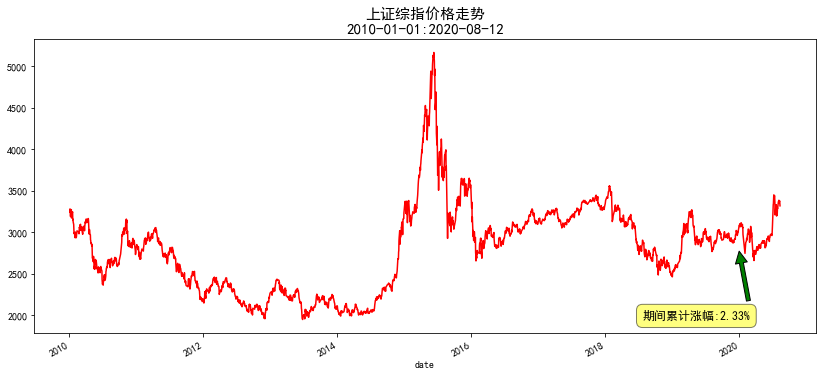

In [28]:
plot_stock('sh','上证综指','2010-01-01','2020-08-12')

In [ ]:
long_list=range(20,70,5)
short_list=range(5,20,5)
main('sh',long_list,short_list,'2010-01-01','2020-08-12')